# Creating binaries 

Given the Prsa et al. 2021 catalog of binary stars, let's make a `ds` for `stella` consisting of the real binaries.

In [1]:
import os, sys
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/stella/')
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/scripts/')
import numpy as np
from utils import *
import models
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob
from tqdm import tqdm
import wotan
import lightkurve as lk
import stella
import pandas as pd
import random
import batman 
import warnings
import re
import shutil

/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


### Import catalog data

In [2]:
data = pd.read_csv('../catalogs/BINARIES-PRSA.tsv',skiprows=38,sep='\t')
data = data.drop(data.index[:2])
data['Sectors'] = data['Sectors'].str.split(',')
data = data.explode('Sectors')
data.TIC = data.TIC.astype(int)
data.Sectors = pd.to_numeric(data['Sectors'], errors='coerce')
data.Per = pd.to_numeric(data['Per'], errors='coerce')
data.BJD0 = pd.to_numeric(data['BJD0'], errors='coerce')

len(data)

12224

### Find TIC IDs for lightcurve files

In [3]:
lightcurves = glob('../data/binaries/*.fits', recursive=True)
ldf = pd.DataFrame(lightcurves)
ldf.columns = ['filepath']
ldf['TIC'] = ldf['filepath'].apply(lambda x: int(re.search(r'(\d{16})', x).group(1)))
ldf['Sectors'] = ldf['filepath'].apply(lambda x: int(re.search(r's(\d{4})', x).group(1)))
len(ldf)

12101

#### Merge datasets

In [4]:
test = pd.merge(data, ldf, on=['TIC','Sectors'])
test = test[['TIC','BJD0','Per','filepath','Sectors']]
test['Sectors'] = test.Sectors.astype(int)
test.head()

,TIC,BJD0,Per,filepath,Sectors
0,185259483,1544.164633,0.310564,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,9
1,307990280,1546.118024,2.315912,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,9
2,307990280,1546.118024,2.315912,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,10
3,307990280,1546.118024,2.315912,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,11
4,387178621,1548.193069,8.187126,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,9


## Functions

In [5]:
def calculate_transit_times(BJD0, period, start, end):
    transit_times = []
    n = 0
    while True:
        T_n = BJD0 + n * period
        if T_n > end:
            break
        if T_n >= start:
            transit_times.append(T_n)
        n += 1
    return transit_times

def process_row(row):
    try:
        sector_index = row['Sectors'] - 1  # Assuming sector numbering starts from 1
        sector_index = int(sector_index)
        sector_times = lightcurves[sector_index]
        return calculate_transit_times(np.array(row['BJD0']), np.array(row['Per']), sector_times[0], sector_times[-1])
    except ValueError:
        # Handle NaN values in 'Sectors' column
        return None
    except Exception as e:
        # Handle other exceptions (e.g., NaN values in 'BJD0' or 'Per' columns)
        print(f"Error processing row: {e}")
        return None


processed_sectors = {}
lightcurves = []

for index, row in tqdm(test.iterrows()):
    sector = row['Sectors']
    filepath = row['filepath']
    
    # Check if this sector has already been processed
    if sector not in processed_sectors:
        # Download the lightcurve (placeholder code, replace with actual download code)
        lightcurve_data, _ = import_lightcurve(filepath)
        
        # Append the lightcurve data to the list
        lightcurves.append(lightcurve_data['TIME'].value)
        
        # Mark this sector as processed
        processed_sectors[sector] = True

lightcurves = sorted(lightcurves, key=lambda x: x[0])

9276it [00:00, 17458.77it/s]


---

### Creating a `stella` catalog table for the binaries 

In [6]:
data1 = test.copy() #data[data.Sectors == 7]
data1 = data1.dropna()

In [7]:
tqdm.pandas()
data1['Transit_Times'] = data1.progress_apply(process_row, axis=1)
data1 = data1.explode('Transit_Times')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9271/9271 [00:01<00:00, 6845.25it/s]


In [8]:
# binary = np.load('../binaries/279955276_sector7.npy')
# plt.plot(binary[0],binary[1])
# for transit_time in list(data[data.TIC == 279955276]['Transit_Times'])[0]:
#     plt.axvline(x=transit_time, color='r', linestyle='--')


In [9]:
#data = pd.DataFrame(data=[ticid,times]).T
data1['tpeak'] = data1['Transit_Times']
data1 = data1.dropna(subset=['Transit_Times'])


In [10]:
data1.head()

,TIC,BJD0,Per,filepath,Sectors,Transit_Times,tpeak
0,185259483,1544.164633,0.310564,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,9,1544.164633,1544.164633
0,185259483,1544.164633,0.310564,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,9,1544.475197,1544.475197
0,185259483,1544.164633,0.310564,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,9,1544.785761,1544.785761
0,185259483,1544.164633,0.310564,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,9,1545.096325,1545.096325
0,185259483,1544.164633,0.310564,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,9,1545.406889,1545.406889


### Filter the subset dataframe for specific sector (if needed)

In [11]:
data2 = data1[data1.Sectors == 18]
data2

,TIC,BJD0,Per,filepath,Sectors,Transit_Times,tpeak
2384,377307592,1684.593763,1.19286,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,18,1790.758312,1790.758312
2384,377307592,1684.593763,1.19286,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,18,1791.951172,1791.951172
2384,377307592,1684.593763,1.19286,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,18,1793.144032,1793.144032
2384,377307592,1684.593763,1.19286,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,18,1794.336892,1794.336892
2384,377307592,1684.593763,1.19286,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,18,1795.529752,1795.529752
...,...,...,...,...,...,...,...
9106,269697721,1712.922460,0.13717,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,18,1814.42826,1814.42826
9106,269697721,1712.922460,0.13717,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,18,1814.56543,1814.56543
9106,269697721,1712.922460,0.13717,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,18,1814.7026,1814.7026
9106,269697721,1712.922460,0.13717,../data/binaries/hlsp_gsfc-eleanor-lite_tess_f...,18,1814.83977,1814.83977


### Save dataframe (this will be in .fits)

In [12]:
name = 'binaries-s18'
folder = f'../models/{name}' 

In [13]:
os.makedirs(folder,exist_ok=True)
for file_path in list(data2.filepath):
    file_path = file_path.strip()  # Remove any leading/trailing whitespace
    if os.path.isfile(file_path):
        shutil.copy(file_path, folder)
    else:
        print(f"File does not exist: {file_path}")

t = Table.from_pandas(data2)
t.write(f'../catalogs/{name}.txt', format='ascii', overwrite=True) 

### Convert FITS to `npy`

In [14]:
files = glob(f'{folder}/*.fits')

In [15]:
for i in files:
    lc, lc_info = import_lightcurve(i)

    flux = lc['PCA_FLUX']/np.nanmedian(lc['PCA_FLUX'])

    f = flux - 1 
    f = f/np.nanstd(f)
    f = 1 + f
    flux = (f - np.min(f)) / (np.max(f) - np.min(f))    
    
    np.save(f"{folder}/{lc_info['TIC_ID']}_sector18.npy", np.array([lc['TIME'], flux, lc['FLUX_ERR'] / np.nanmedian(lc['PCA_FLUX'])]))

and done!

## Read in your new dataset

In [16]:
ds = stella.FlareDataSet(fn_dir=f'/Users/azib/Documents/open_source/nets2/models/{name}/',
                         catalog=f'/Users/azib/Documents/open_source/nets2/catalogs/{name}.txt',cadences=168,training=0.8,validation=0.1)

Reading in training set files.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [00:00<00:00, 1481.78it/s]


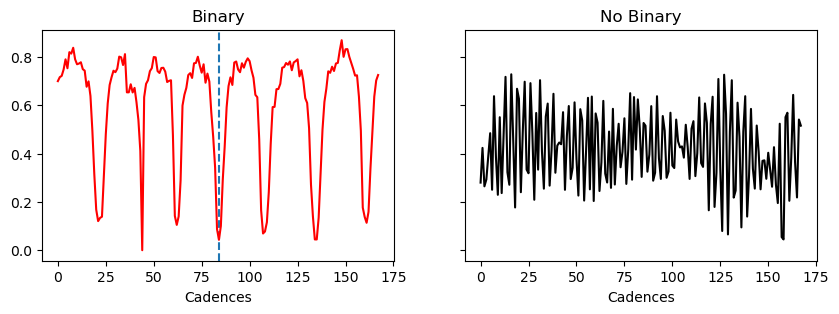

In [32]:
n = 14

ind_pc = np.where(ds.train_labels==1)[0] # Flares
ind_nc = np.where(ds.train_labels==0)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[n]], 'r',zorder=5)
ax1.axvline(84,linestyle='--')
ax1.set_title('Binary')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[n]], 'k')
ax2.set_title('No Binary')
ax2.set_xlabel('Cadences');

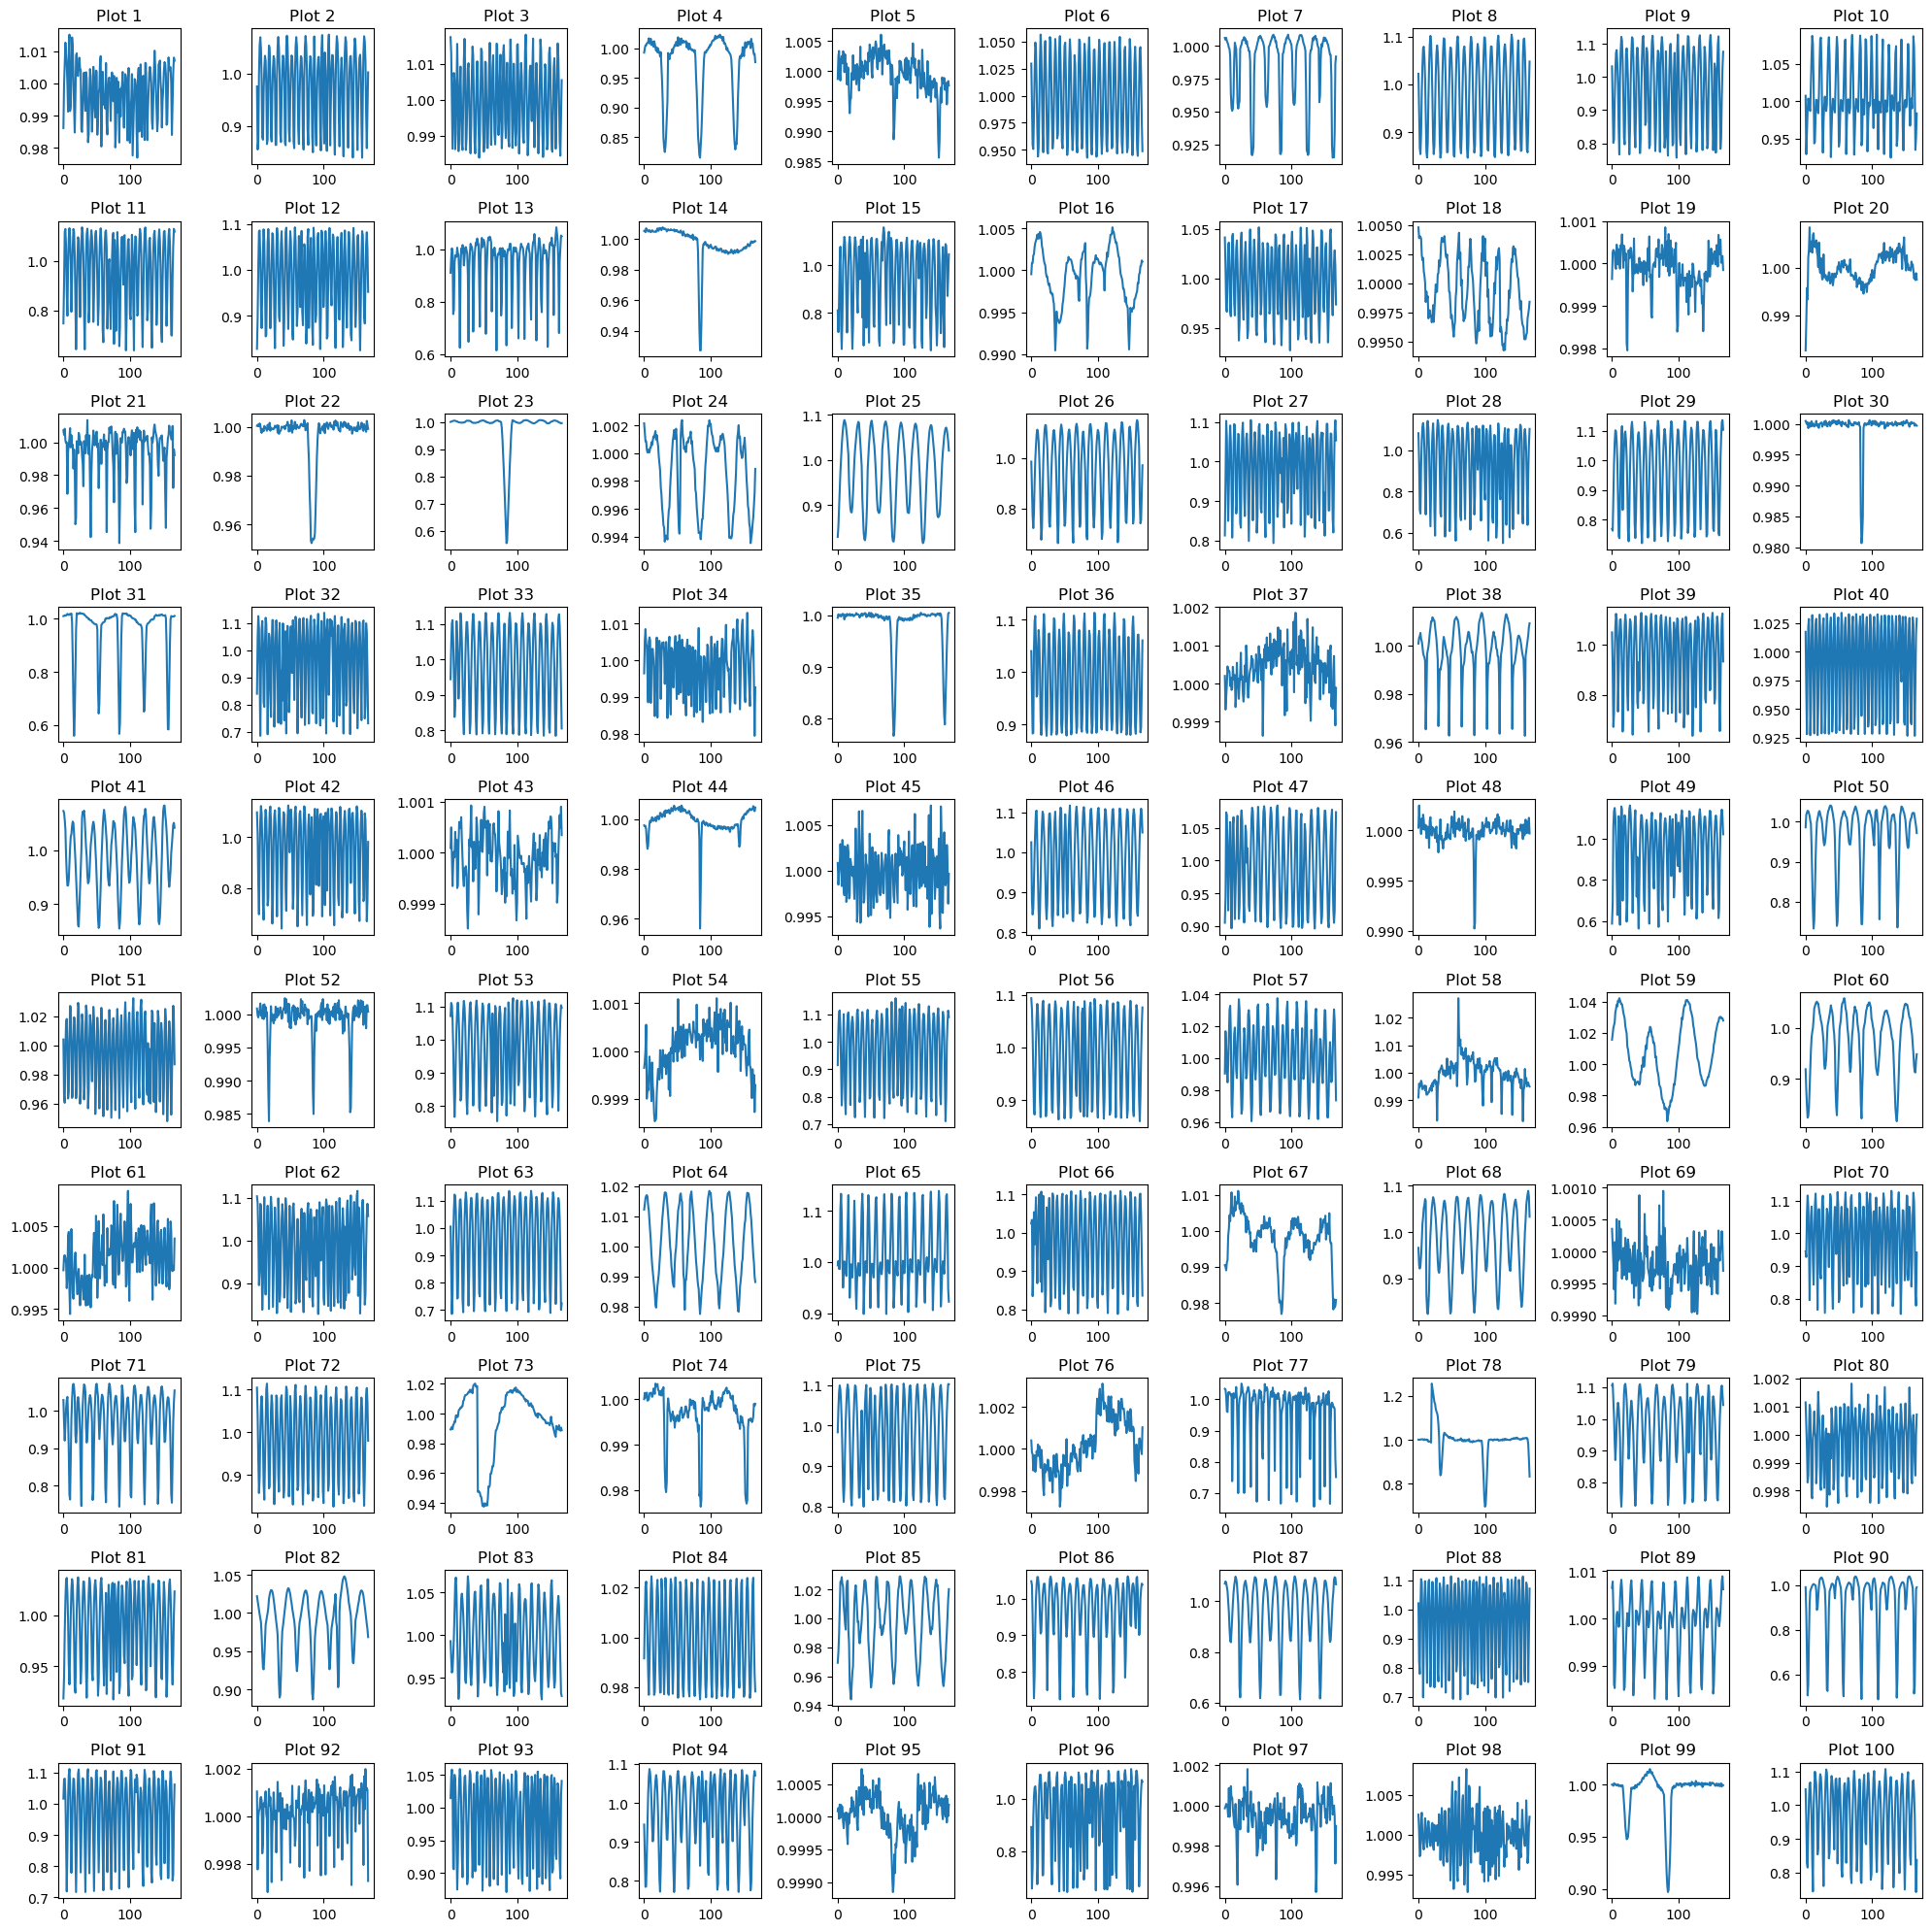

In [16]:
dsmodels = ds.train_data[ind_pc]
dsnomodels = ds.train_data[ind_nc]

num_sets = dsmodels.shape[0] // 100

for set_index in range(num_sets):
    start_index = set_index * 100
    end_index = min((set_index + 1) * 100, dsmodels.shape[0])  # Ensure not to exceed the length of the data

    # Create a new 10x10 grid of subplots for each set
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Iterate over the elements in the current set and plot each in the grid
    for i in range(start_index, end_index):
        plot_index = i % 100  # Calculate the index within the current grid
        axs[plot_index].plot(dsmodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
        axs[plot_index].set_title(f"Plot {i+1}")  # Title for each subplot

    # Hide any remaining empty subplots
    for j in range(end_index - start_index, len(axs)):
        axs[j].axis('off')

    
    plt.tight_layout()  # Adjust layout
    #plt.savefig('example-models.png',dpi=200,bbox_inches='tight')
    plt.show()  # Show the grid of plots
    break

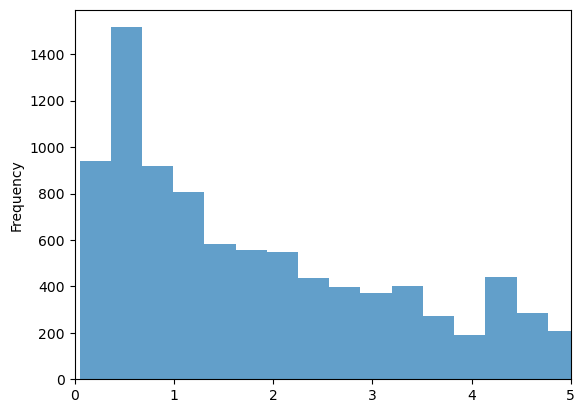

In [17]:
data['Per'].plot.hist(bins=1000, alpha=0.7)
plt.xlim(0,5)
plt.show()